In [1]:
import numpy as np
import numpy.ma as ma
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
from iris.time import PartialDateTime
from iris.util import mask_cube_from_shapefile
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely import MultiPolygon, Polygon
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
import sklearn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torch.utils.data import Dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
filenames = ['C:/Users/Tilt/Downloads/Project/Data/data_2010.nc','C:/Users/Tilt/Downloads/Project/Data/data_2011.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2012.nc','C:/Users/Tilt/Downloads/Project/Data/data_2013.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2014.nc','C:/Users/Tilt/Downloads/Project/Data/data_2015.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2016.nc','C:/Users/Tilt/Downloads/Project/Data/data_2017.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2018.nc','C:/Users/Tilt/Downloads/Project/Data/data_2019.nc']
cubes = iris.load(filenames)
cubes = cubes.concatenate()
print(cubes)

0: population_density / (unknown)      (time: 120; latitude: 720; longitude: 1440)
1: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
2: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
3: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
4: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
5: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
6: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
7: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
8: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
9: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
10: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
11: 10 metre wind speed / (m s**-1)     (time: 120; latitude: 720; longitude: 1440)
12: 2 metre temperature / (K)           (time: 120; latitude: 720; longitude: 1440)
13: Convective available pot

In [3]:
ConstraintNames = [
    'burned_area',
    'population_density',
    '10 metre wind speed',
    '2 metre temperature',
    'Convective available potential energy',
    'Leaf area index, high vegetation',
    'Leaf area index, low vegetation',
    'Total precipitation',
    'Volumetric soil water layer 1',
    'observed_fraction_mask',
    'standard error of the estimation of burned area'
]

cubesList = { name: cubes.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 120; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 120; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 120; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 120; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 120; latitude: 720; longitude: 1440)>, 'Volu

In [4]:
# For Madagascar, Change CountryName to 'Madagascar'

CountryName = "Portugal"

country_shp_reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="110m", category="cultural", name="admin_0_countries"
    )
)
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
ObsMaskCube = iris.analysis.maths.log(ObsMaskCube)
ObsMaskCube = iris.analysis.maths.exp(ObsMaskCube)

b=0
a = ObsMaskCube.data
print("Verification - Count should Equal Sum")
print("Count =",ma.count(a))
print("Sum =",np.sum(a))
if(np.round(np.sum(a)) == ma.count(a)):
    b=b+1
print("Verification Mean should = 1")
print("Mean = ",np.mean(a))
if(np.round(np.mean(a)) == 1):
    b=b+1
print("We have",ma.count(a),"Datapoints Per Month")
if(b==2):
    print("All Verified - Continue")
else:
    print("Somethings gone wrong.")

BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)
PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


Verification - Count should Equal Sum
Count = 173
Sum = 173.0
Verification Mean should = 1
Mean =  1.0
We have 173 Datapoints Per Month
All Verified - Continue


c:\Users\Tilt\miniconda3\Lib\site-packages\dask\core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


(120, 720, 1440)
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
20760
173


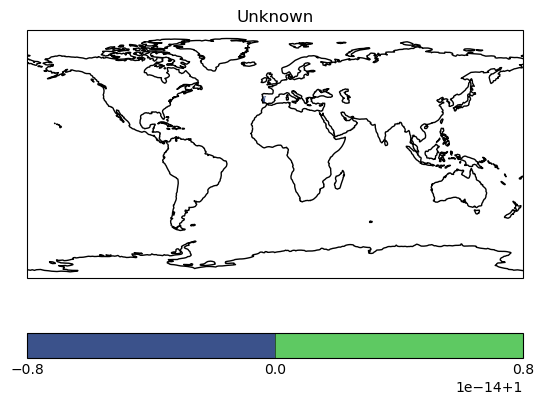

In [5]:
a = BurnedCube.data
print(np.shape(a))
aNoMask = a[~a.mask]
print(aNoMask)
print(len(aNoMask))

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))
# 173 Datapoints Per for Portugal
Timesteps = round(len(aNoMask)/len(aNoMaskMonth))
Samples = len(aNoMaskMonth)

qplt.contourf(ObsMaskCube, 25)
plt.gca().coastlines()
plt.show()

In [6]:
def DeCube(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(Timesteps, Samples)
    return InCube

In [7]:
#Verifying this doesnt break it
#a = BurnedCube.data
#a = a[~a.mask]
#print(len(a))

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

Popn = np.log(Popn)

scaler = MinMaxScaler()
scaler.fit(Popn)
Popn = scaler.transform(Popn) 
scaler.fit(Wind)
Wind = scaler.transform(Wind) 
scaler.fit(Temp)
Temp = scaler.transform(Temp) 
scaler.fit(CAPE)
CAPE = scaler.transform(CAPE) 
scaler.fit(HVeg)
HVeg = scaler.transform(HVeg) 
scaler.fit(LVeg)
LVeg = scaler.transform(LVeg) 
scaler.fit(Precip)
Precip = scaler.transform(Precip) 
scaler.fit(Soil)
Soil = scaler.transform(Soil) 

SECube = iris.analysis.maths.multiply(cubesList['standard error of the estimation of burned area'], ObsMaskCube)
SE = DeCube(SECube)

X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil,SE))
print(X_full.shape)
X_full2D = X_full.reshape(-1, X_full.shape[-1])
print(X_full2D.shape)

y_full = Burned
y_full2D = y_full.reshape(X_full2D.shape[0],1)
y_full2DBinary = y_full2D
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full2D, y_full2DBinary, test_size = 0.2, random_state = 42)

SE = X_test[:,-1]
X_train = X_train[:,0:8]
X_test = X_test[:,0:8]

print("Training Shape",X_train.shape,y_train.shape)
print("Testing Shape",X_test.shape,y_test.shape)

y_testFull = y_test

y_train[y_train>0]=1
y_train[y_train==0]=0
y_test[y_test>0]=1
y_test[y_test==0]=0


(120, 173, 9)
(20760, 9)
Training Shape (16608, 8) (16608, 1)
Testing Shape (4152, 8) (4152, 1)


In [8]:
from sklearn.neighbors import KNeighborsClassifier
regressor = KNeighborsClassifier(n_neighbors=5,p=2)
regressor.fit(X_train, y_train.ravel())

KNeighborsClassifier()

Text(0.5, 1.0, 'Confusion Matrix for K-NN Classifier (K=7) - Overfitted - Portugal')

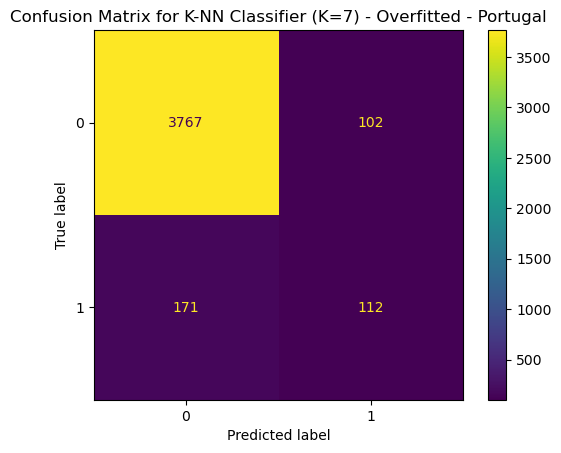

In [9]:
y_pred = regressor.predict(X_test)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for K-NN Classifier (K=7) - Overfitted - Portugal")

In [10]:
SE = SE.reshape(SE.shape[0],1)
compcol2 = np.vstack((y_pred,y_test.ravel()))
print(compcol2.shape)
XTest2 = np.zeros((X_test.shape[0],X_test.shape[1]))
y_test2 = np.zeros((y_test.shape[0],y_test.shape[1]))
SE2 = np.zeros((SE.shape[0],1))
for i in range(compcol2.shape[1]):
    if compcol2[1,i]>0:
        if compcol2[0,i]>0:
            XTest2[i,:]=X_test[i,:]
            y_test2[i,:]=y_test[i,:]
            SE2[i,:]=SE[i,:]
print(XTest2.shape)
XTest2 = XTest2[~np.all(XTest2 == 0, axis=1)]
y_test2 = y_test2[~np.all(y_test2 == 0, axis=1)]
SE2 = SE2[~np.all(SE2 == 0, axis=1)]
print(XTest2.shape)

(2, 4152)
(4152, 8)
(112, 8)


In [11]:
X_full2 = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil,Burned))
print(X_full2.shape)
X_full2 = X_full2.reshape(-1, X_full2.shape[-1])
print(X_full2.shape)
X_fullNonZero = X_full2[X_full2[:,-1]>0]
print(X_fullNonZero.shape)
y_fullNonZero = X_fullNonZero[:,-1]
X_fullNonZero = X_fullNonZero[:,0:8]
NumNonZero = X_fullNonZero.shape[0]
y_fullNonZero = (y_fullNonZero)
y_fullNonZero = y_fullNonZero.reshape(NumNonZero,1)
np.random.seed(42)
sample = np.random.choice([True, True, True, True, False], (NumNonZero, 1))
print(sample.shape)
X_fullNonZeroTrain = X_fullNonZero * sample
X_fullNonZeroTest = X_fullNonZero * (1-sample)
#print(X_fullNonZeroTrain)
y_NonZeroTrain = y_fullNonZero * sample
y_NonZeroTest = y_fullNonZero * (1-sample)
X_fullNonZeroTrain = X_fullNonZeroTrain[~np.all(X_fullNonZeroTrain == 0, axis=1)]
X_fullNonZeroTest = X_fullNonZeroTest[~np.all(X_fullNonZeroTest == 0, axis=1)]
y_NonZeroTrain = y_NonZeroTrain[~np.all(y_NonZeroTrain == 0, axis=1)]
y_NonZeroTest = y_NonZeroTest[~np.all(y_NonZeroTest == 0, axis=1)]

#y_train = np.log(y_train)
#y_test = np.log(y_test)

#scalerY = sklearn.preprocessing.quantile_transform()
#scalerY.fit(y_train)
#y_train = scalerY.transform(y_train) 
#y_test = scalerY.transform(y_test) 

print("Training Shape",X_fullNonZeroTrain.shape,y_NonZeroTrain.shape)
print("Testing Shape",X_fullNonZeroTest.shape,y_NonZeroTest.shape)

(120, 173, 9)
(20760, 9)
(1500, 9)
(1500, 1)
Training Shape (1189, 8) (1189, 1)
Testing Shape (311, 8) (311, 1)


In [12]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=5,weights='distance',p=2)
regressor.fit(X_fullNonZeroTrain, y_NonZeroTrain.ravel())
y_pred = regressor.predict(XTest2)
print(y_pred.shape)
#print(y_test.ravel().shape)
Delta = y_test2.ravel() - y_pred
Delta = np.abs(Delta)
Delta = Delta.reshape(Delta.shape[0],1)
print(Delta.shape)
print(SE2.shape)
#print(Delta.mean())

(112,)
(112, 1)
(112, 1)


In [13]:
CompCol = np.hstack((2*SE2,Delta))
IsAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsAccurateCol.shape[0])
for i in range(IsAccurateCol.shape[0]):
    if CompCol[i,1] > CompCol[i,0]:
        IsAccurateCol[i,0] = 0
    else:
        IsAccurateCol[i,0] = 1
print("Percentage of Predictions within 2*SE of Burned Area =",IsAccurateCol.mean())

Percentage of Predictions within 2*SE of Burned Area = 0.29464285714285715


In [17]:
print(cm)
acc = cm[0][0]+cm[1][1]*IsAccurateCol.mean()
print(acc)
acc = acc/(cm[0][0]+cm[1][0]+cm[0][1]+cm[1][1])
print("All-In-One Combined Accuracy = ", acc)

[[3767  102]
 [ 171  112]]
3800.0
All-In-One Combined Accuracy =  0.9152215799614644
